In [3]:
# Visualization
%load_ext autoreload
%autoreload 2
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

In [26]:
# Get weight file
%cd ~/composition/logs/peopleart_coco
weight_file = !ls -Art | grep efficientdet
%cd ../..

#uncomment the next line to specify a weight file
# weight_file[-1] = 'efficientdet-d0_1_32.pth' # untrained
# weight_file[-1] = 'efficientdet-d0_49_800.pth' # 50 epochs
weight_file[-1] = 'efficientdet-d0_149_600.pth' # ~150 epochs


# Evaluate for AP scores
# ! python coco_eval.py -c 0 -p peopleart_coco -w "logs/peopleart_coco/{weight_file[-1]}"

/home/sleepearly/composition/logs/peopleart_coco
/home/sleepearly/composition


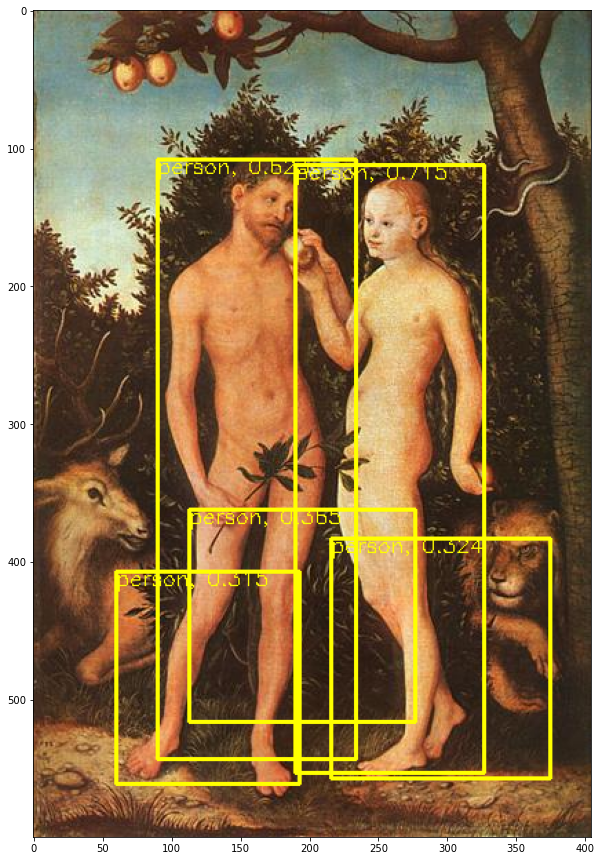

In [27]:
# Visualize prediction
compound_coef = 0
force_input_size = None  # set None to use default size
# img_path = 'datasets/el-greco_the-last-supper.jpg'
img_path = 'datasets/lucas-cranach_adam-and-eve-1531-1.jpg'
# img_path = 'datasets/peopleart_coco/val/1809.jpg' 
# img_path = 'datasets/peopleart_coco/val/1652.jpg'

threshold = 0.3
iou_threshold = 0.3

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['person']

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load('logs/peopleart_coco/'+weight_file[-1]))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

plt.figure(figsize=(10,20))
for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)
        plt.imshow(ori_imgs[i])

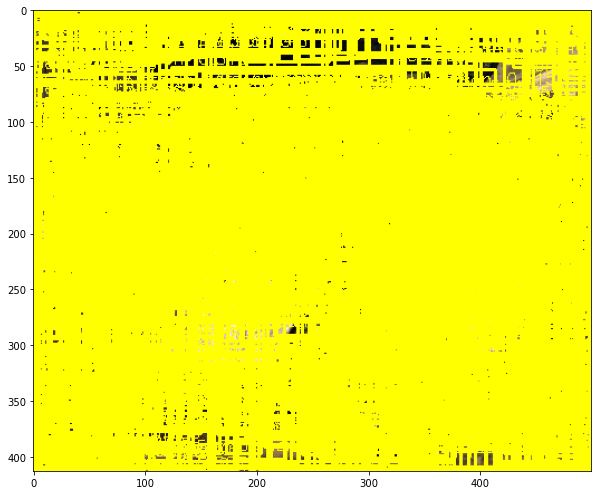

In [17]:
plt.figure(figsize=(10,20))
for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])
        
        if score < 0.997:
            continue
            
        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)
        plt.imshow(ori_imgs[i])

In [6]:
# Check image shapes
sample_img = cv2.imread(img_path)
sample_img.shape


(500, 488, 3)